In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, matthews_corrcoef, accuracy_score, f1_score, silhouette_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cluster import KMeans
from IPython.display import FileLink, FileLinks, clear_output
from IPython.display import FileLink, FileLinks
import timeit

In [2]:
df = pd.read_csv(r"C:\Users\rrava\OneDrive\Documents\01 - Fall 2022\Research Project\Clean Datasets\mustang.csv")
df = df.sort_values(by='submit_time', ascending=True)
df = df.iloc[10000:35000 , :]
df.head()

,user_ID,group_ID,submit_time,start_time,end_time,wallclock_limit,job_status,node_count,tasks_requested
9975,144,145,2012-02-17 12:19:07-07:00,2012-02-17 12:19:35-07:00,2012-02-17 17:08:37-07:00,0 days 08:00:00.000000000,COMPLETED,6,144
9974,144,145,2012-02-17 12:19:28-07:00,2012-02-17 12:19:35-07:00,2012-02-17 17:06:17-07:00,0 days 08:00:00.000000000,COMPLETED,6,144
9988,144,145,2012-02-17 12:20:51-07:00,2012-02-17 12:23:50-07:00,2012-02-17 20:23:51-07:00,0 days 08:00:00.000000000,TIMEOUT,6,144
9968,23,23,2012-02-17 12:21:06-07:00,2012-02-17 12:23:50-07:00,2012-02-17 14:42:32-07:00,0 days 04:00:00.000000000,COMPLETED,2,48
10048,144,145,2012-02-17 12:21:37-07:00,2012-02-17 12:23:50-07:00,2012-02-18 00:23:51-07:00,0 days 12:00:00.000000000,TIMEOUT,6,144


In [3]:
df = df.dropna(subset=['start_time'], axis=0, how='any')
df = df.dropna(subset=['submit_time'], axis=0, how='any')
df = df.dropna(subset=['end_time'], axis=0, how='any')
df = df[df.job_status == 'COMPLETED']
df.head()

,user_ID,group_ID,submit_time,start_time,end_time,wallclock_limit,job_status,node_count,tasks_requested
9975,144,145,2012-02-17 12:19:07-07:00,2012-02-17 12:19:35-07:00,2012-02-17 17:08:37-07:00,0 days 08:00:00.000000000,COMPLETED,6,144
9974,144,145,2012-02-17 12:19:28-07:00,2012-02-17 12:19:35-07:00,2012-02-17 17:06:17-07:00,0 days 08:00:00.000000000,COMPLETED,6,144
9968,23,23,2012-02-17 12:21:06-07:00,2012-02-17 12:23:50-07:00,2012-02-17 14:42:32-07:00,0 days 04:00:00.000000000,COMPLETED,2,48
9982,104,105,2012-02-17 12:28:47-07:00,2012-02-17 19:39:20-07:00,2012-02-17 19:52:03-07:00,0 days 14:00:00.000000000,COMPLETED,20,480
10000,100,101,2012-02-17 13:03:57-07:00,2012-02-17 15:36:23-07:00,2012-02-17 21:22:24-07:00,0 days 12:00:00.000000000,COMPLETED,25,600


In [4]:
df['start_time']= pd.to_datetime(df['start_time'])
df['submit_time']= pd.to_datetime(df['submit_time'])
df['end_time']= pd.to_datetime(df['end_time'])
df['wallclock_limit']= (pd.to_timedelta(df['wallclock_limit'])).dt.total_seconds()

In [5]:
df['runtime'] = (df['end_time'] - df['start_time']).dt.total_seconds()
df['waiting_time'] = (df['start_time'] - df['submit_time']).dt.total_seconds()
df['CPU_time'] = df['tasks_requested'] * df['wallclock_limit']
df.head()

,user_ID,group_ID,submit_time,start_time,end_time,wallclock_limit,job_status,node_count,tasks_requested,runtime,waiting_time,CPU_time
9975,144,145,2012-02-17 12:19:07-07:00,2012-02-17 12:19:35-07:00,2012-02-17 17:08:37-07:00,28800.0,COMPLETED,6,144,17342.0,28.0,4147200.0
9974,144,145,2012-02-17 12:19:28-07:00,2012-02-17 12:19:35-07:00,2012-02-17 17:06:17-07:00,28800.0,COMPLETED,6,144,17202.0,7.0,4147200.0
9968,23,23,2012-02-17 12:21:06-07:00,2012-02-17 12:23:50-07:00,2012-02-17 14:42:32-07:00,14400.0,COMPLETED,2,48,8322.0,164.0,691200.0
9982,104,105,2012-02-17 12:28:47-07:00,2012-02-17 19:39:20-07:00,2012-02-17 19:52:03-07:00,50400.0,COMPLETED,20,480,763.0,25833.0,24192000.0
10000,100,101,2012-02-17 13:03:57-07:00,2012-02-17 15:36:23-07:00,2012-02-17 21:22:24-07:00,43200.0,COMPLETED,25,600,20761.0,9146.0,25920000.0


In [6]:
runtimes = df['runtime']
runtimes.describe()
underHour = df[df['runtime'] < (60 * 60)].index
print("Jobs under 1 hour: " + str(len(underHour) / len(runtimes)))
under15 = df[df['runtime'] < (60 * 15)].index
print("Jobs under 15 mins: " + str(len(under15) / len(runtimes)))

Jobs under 1 hour: 0.8856604635232332
Jobs under 15 mins: 0.8128781824409179


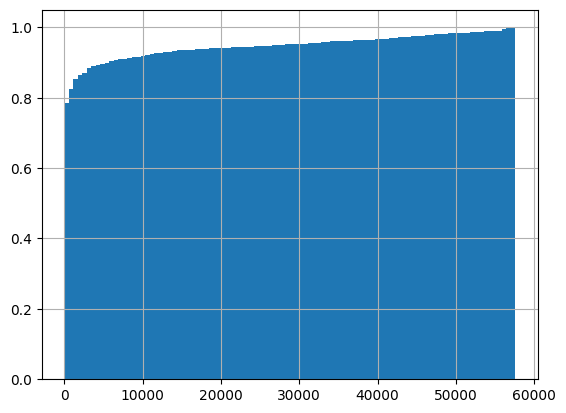

In [7]:
runtimes.hist(cumulative=True, density=1, bins=100)
plt.show()

In [8]:
df['runtime'].describe()

count    17518.000000
mean      3184.493778
std      10295.687781
min          0.000000
25%          9.000000
50%         31.000000
75%        308.000000
max      57557.000000
Name: runtime, dtype: float64

In [9]:
len(df)

17518

In [ ]:
df['num_running_jobs'] = np.nan
df['running_job_requested_CPUs'] = np.nan
df['running_job_requested_CPU_time'] = np.nan
df['running_job_requested_wallclock_limit'] = np.nan
df['running_job_nodes_assigned'] = np.nan

df['running_job_mean_CPUs'] = 0
df['running_job_mean_CPU_time'] = 0
df['running_job_mean_wallclock_limit'] = 0
df['elapsed_runtime_total'] = 0
df['elapsed_runtime_mean'] = 0

df['num_waiting_jobs'] = np.nan
df['waiting_job_requested_CPUs'] = np.nan
df['waiting_job_requested_CPU_time'] = np.nan
df['waiting_job_requested_wallclock_limit'] = np.nan

df['waiting_job_mean_CPUs'] = 0
df['waiting_job_mean_CPU_time'] = 0
df['waiting_job_mean_wallclock_limit'] = 0
df['elapsed_waiting_time_total'] = 0
df['elapsed_waiting_time_mean'] = 0

start = timeit.default_timer()
for a in range (len(df)):
    clear_output(wait=True)
    submit_time = df.iloc[a].submit_time
    
    started_jobs = df.loc[df[df['start_time'] < submit_time].index]
    running_jobs = started_jobs[started_jobs['end_time'] > submit_time].index
    
    running_requested_CPUs = df.loc[running_jobs, 'tasks_requested'].sum()
    running_requested_CPU_time = df.loc[running_jobs, 'CPU_time'].sum()
    running_requested_wallclock_limit = df.loc[running_jobs, 'wallclock_limit'].sum()
    running_nodes_assigned = df.loc[running_jobs, 'node_count'].sum()
    df.iloc[a, df.columns.get_loc('num_running_jobs')] = len(running_jobs)
    df.iloc[a, df.columns.get_loc('running_job_requested_CPUs')] = running_requested_CPUs
    df.iloc[a, df.columns.get_loc('running_job_requested_CPU_time')] = running_requested_CPU_time
    df.iloc[a, df.columns.get_loc('running_job_requested_wallclock_limit')] = running_requested_wallclock_limit
    df.iloc[a, df.columns.get_loc('running_job_nodes_assigned')] = running_nodes_assigned
    
    elapsed_runtime = (submit_time - df.loc[running_jobs, 'start_time']).sum()
    df.iloc[a, df.columns.get_loc('elapsed_runtime_total')] = elapsed_runtime
    
    if len(running_jobs) > 0:
        df.iloc[a, df.columns.get_loc('running_job_mean_CPUs')] = running_requested_CPUs / len(running_jobs)
        df.iloc[a, df.columns.get_loc('running_job_mean_CPU_time')] = running_requested_CPU_time / len(running_jobs)
        df.iloc[a, df.columns.get_loc('running_job_mean_wallclock_limit')] = running_requested_wallclock_limit / len(running_jobs) 
        df.iloc[a, df.columns.get_loc('elapsed_runtime_total')] = elapsed_runtime.total_seconds()
        df.iloc[a, df.columns.get_loc('elapsed_runtime_mean')] = (elapsed_runtime / len(running_jobs)).total_seconds()
        
    submitted_jobs = df.loc[df[df['submit_time'] < submit_time].index]
    waiting_jobs = submitted_jobs[submitted_jobs['start_time'] > submit_time].index
    
    waiting_requested_CPUs = df.loc[waiting_jobs, 'tasks_requested'].sum()
    waiting_requested_CPU_time = df.loc[waiting_jobs, 'CPU_time'].sum()
    waiting_requested_wallclock_limit = df.loc[waiting_jobs, 'wallclock_limit'].sum()
    df.iloc[a, df.columns.get_loc('num_waiting_jobs')] = len(waiting_jobs)
    df.iloc[a, df.columns.get_loc('waiting_job_requested_CPUs')] = waiting_requested_CPUs
    df.iloc[a, df.columns.get_loc('waiting_job_requested_CPU_time')] = waiting_requested_CPU_time
    df.iloc[a, df.columns.get_loc('waiting_job_requested_wallclock_limit')] = waiting_requested_wallclock_limit
    
    elapsed_waiting_time = (submit_time - df.loc[waiting_jobs, 'submit_time']).sum()
    df.iloc[a, df.columns.get_loc('elapsed_waiting_time_total')] = elapsed_waiting_time
    
    if len(waiting_jobs) > 0:
        df.iloc[a, df.columns.get_loc('waiting_job_mean_CPUs')] = waiting_requested_CPUs / len(waiting_jobs)
        df.iloc[a, df.columns.get_loc('waiting_job_mean_CPU_time')] = waiting_requested_CPU_time / len(waiting_jobs)
        df.iloc[a, df.columns.get_loc('waiting_job_mean_wallclock_limit')] = waiting_requested_wallclock_limit / len(waiting_jobs) 
        df.iloc[a, df.columns.get_loc('elapsed_waiting_time_total')] = elapsed_waiting_time.total_seconds()
        df.iloc[a, df.columns.get_loc('elapsed_waiting_time_mean')] = (elapsed_waiting_time / len(waiting_jobs)).total_seconds()
        
    stop = timeit.default_timer()
    expected_time = np.round( ( (stop - start) / (max(a,1) / len(df)) ) / 60, 2)
    print("Current progress: ", np.round(a / len(df) * 100, 2), "%")
    print("Current runtime: ", np.round((stop - start) / 60, 2), "minutes")
    print("Expected runtime: ", expected_time, "minutes")

Current progress:  0.41 %
Current runtime:  0.06 minutes
Expected runtime:  13.6 minutes


In [ ]:
x = df[['user_ID', 'group_ID', 'wallclock_limit', 'tasks_requested', 'CPU_time', 'num_running_jobs', 'num_waiting_jobs', 'running_job_requested_CPUs', 'running_job_requested_CPU_time', 'running_job_mean_CPUs', 'running_job_mean_CPU_time', 'running_job_requested_wallclock_limit', 'running_job_mean_wallclock_limit', 'running_job_nodes_assigned', 'waiting_job_requested_CPUs', 'waiting_job_requested_CPU_time', 'waiting_job_mean_CPUs', 'waiting_job_mean_CPU_time', 'waiting_job_requested_wallclock_limit', 'waiting_job_mean_wallclock_limit', 'elapsed_runtime_total', 'elapsed_runtime_mean', 'elapsed_waiting_time_total', 'elapsed_waiting_time_mean']]
y = df[['waiting_time']]

In [ ]:
x

In [ ]:
y

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
#Random forest regression

random_forest_regressor = RandomForestRegressor(n_estimators = 50, random_state = 0)
random_forest_regressor.fit(x_train, y_train.values.ravel())

y_pred = random_forest_regressor.predict(x_test)

y_test_binary = y_test < (24 * 60)
y_pred_binary = y_pred < (24 * 60)

print("Random forest mean absolute error (mins) : " + str(mean_absolute_error(y_test, y_pred) / 60))
print("Random forest accuracy: " + str(accuracy_score(y_test_binary, y_pred_binary)))
print("Random forest f1 score: " + str(f1_score(y_test_binary, y_pred_binary)))
print("Random forest MCC: " + str(matthews_corrcoef(y_test_binary, y_pred_binary)))

In [ ]:
#Linear regression

linear_regressor = LinearRegression()  
linear_regressor.fit(x_train, y_train)

y_pred = linear_regressor.predict(x_test)

y_test_binary = y_test < (24 * 60)
y_pred_binary = y_pred < (24 * 60)

print("Linear regression mean absolute error (mins) : " + str(mean_absolute_error(y_test, y_pred) / 60))
print("Linear regression accuracy: " + str(accuracy_score(y_test_binary, y_pred_binary)))
print("Linear regression f1 score: " + str(f1_score(y_test_binary, y_pred_binary)))
print("Linear regression MCC: " + str(matthews_corrcoef(y_test_binary, y_pred_binary)))

In [ ]:
#Gradient boosting

gb_regressor = GradientBoostingRegressor(random_state=0)
gb_regressor.fit(x_train, y_train.values.ravel())

y_pred = gb_regressor.predict(x_test)

y_test_binary = y_test < (24 * 60)
y_pred_binary = y_pred < (24 * 60)

print("Gradient boosting mean absolute error (mins) : " + str(mean_absolute_error(y_test, y_pred) / 60))
print("Gradient boosting accuracy: " + str(accuracy_score(y_test_binary, y_pred_binary)))
print("Gradient boosting f1 score: " + str(f1_score(y_test_binary, y_pred_binary)))
print("Gradient boosting MCC: " + str(matthews_corrcoef(y_test_binary, y_pred_binary)))

In [ ]:
#Waiting time classification

df['waiting_time_threshold'] = df['waiting_time'] < (24* 60)
y = df[['waiting_time_threshold']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
#Random forest classification

clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf.fit(x_train, y_train.values.ravel())

y_pred = clf.predict(x_test)

print("Classification f1 score: " + str(f1_score(y_test, y_pred)))
print("Classification accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Classification MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Logistic regression

logisticRegr = LogisticRegression(max_iter = 1000, random_state = 0)
logisticRegr.fit(x_train, y_train.values.ravel())

y_pred = logisticRegr.predict(x_test)

print("Logistic regression f1 score: " + str(f1_score(y_test, y_pred)))
print("Logistic regression accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Logistic regression MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Nearest neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train.values.ravel())

y_pred = knn.predict(x_test)

print("Nearest neighbors f1 score: " + str(f1_score(y_test, y_pred)))
print("Nearest neighbors accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Nearest neighbors MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#SVM

svm = SVC()
svm.fit(x_train, y_train.values.ravel())

y_pred = svm.predict(x_test)

print("SVM f1 score: " + str(f1_score(y_test, y_pred)))
print("SVM accuracy: " + str(accuracy_score(y_test, y_pred)))
print("SVM MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Naive Bayes

naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train.values.ravel())

y_pred = naive_bayes.predict(x_test)

print("Naive Bayes f1 score: " + str(f1_score(y_test, y_pred)))
print("Naive Bayes accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Naive Bayes MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Custom approach - classification

df['should_wait'] = (df['runtime'] > (15 * 60)) & (df['waiting_time'] < (24* 60))
y = df[['should_wait']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
#Random forest classification

clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf.fit(x_train, y_train.values.ravel())

y_pred = clf.predict(x_test)

print("Classification f1 score: " + str(f1_score(y_test, y_pred)))
print("Classification accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Classification MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Logistic regression

logisticRegr = LogisticRegression(max_iter = 1000, random_state = 0)
logisticRegr.fit(x_train, y_train.values.ravel())

y_pred = logisticRegr.predict(x_test)

print("Logistic regression f1 score: " + str(f1_score(y_test, y_pred)))
print("Logistic regression accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Logistic regression MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Nearest neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train.values.ravel())

y_pred = knn.predict(x_test)

print("Nearest neighbors f1 score: " + str(f1_score(y_test, y_pred)))
print("Nearest neighbors accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Nearest neighbors MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#SVM

svm = SVC()
svm.fit(x_train, y_train.values.ravel())

y_pred = svm.predict(x_test)

print("SVM f1 score: " + str(f1_score(y_test, y_pred)))
print("SVM accuracy: " + str(accuracy_score(y_test, y_pred)))
print("SVM MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Naive Bayes

naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train.values.ravel())

y_pred = naive_bayes.predict(x_test)

print("Naive Bayes f1 score: " + str(f1_score(y_test, y_pred)))
print("Naive Bayes accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Naive Bayes MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Runtime classification
df['should_wait_runtime'] = df['runtime'] > (15 * 60)
x = df[['user_ID', 'group_ID', 'wallclock_limit', 'tasks_requested']]
y = df[['should_wait_runtime']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, shuffle = True, random_state = 0)

In [ ]:
#Random forest classification

clf = RandomForestClassifier(n_estimators = 100, random_state = 0)
clf.fit(x_train, y_train.values.ravel())

y_pred = clf.predict(x_test)

print("Classification f1 score: " + str(f1_score(y_test, y_pred)))
print("Classification accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Classification MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Logistic regression

logisticRegr = LogisticRegression(max_iter = 1000, random_state = 0)
logisticRegr.fit(x_train, y_train.values.ravel())

y_pred = logisticRegr.predict(x_test)

print("Logistic regression f1 score: " + str(f1_score(y_test, y_pred)))
print("Logistic regression accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Logistic regression MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Nearest neighbors

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(x_train, y_train.values.ravel())

y_pred = knn.predict(x_test)

print("Nearest neighbors f1 score: " + str(f1_score(y_test, y_pred)))
print("Nearest neighbors accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Nearest neighbors MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#SVM

svm = SVC()
svm.fit(x_train, y_train.values.ravel())

y_pred = svm.predict(x_test)

print("SVM f1 score: " + str(f1_score(y_test, y_pred)))
print("SVM accuracy: " + str(accuracy_score(y_test, y_pred)))
print("SVM MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
#Naive Bayes

naive_bayes = GaussianNB()
naive_bayes.fit(x_train, y_train.values.ravel())

y_pred = naive_bayes.predict(x_test)

print("Naive Bayes f1 score: " + str(f1_score(y_test, y_pred)))
print("Naive Bayes accuracy: " + str(accuracy_score(y_test, y_pred)))
print("Naive Bayes MCC: " + str(matthews_corrcoef(y_test, y_pred)))

In [ ]:
df.to_csv(r'C:\Users\rrava\OneDrive\Documents\01 - Fall 2022\Research Project\Models\dataframe.csv', index=False)